<a href="https://colab.research.google.com/github/p0nguin/start-again/blob/main/modelsandcatastrophe_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

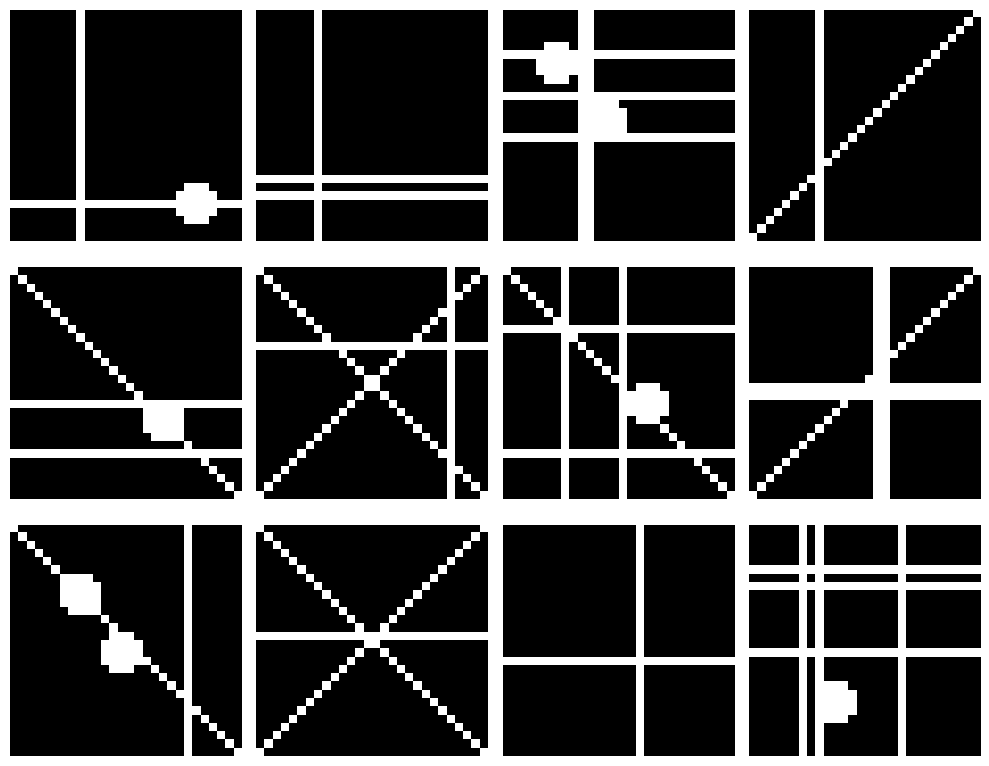

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt

# Synthetic image generator: mix of dot, line, cross, etc.
def draw_composite_image(n_shapes=3):
    img = Image.new("L", (28, 28), color=0)
    draw = ImageDraw.Draw(img)

    for _ in range(n_shapes):
        choice = random.choice(["dot", "horizontal", "vertical", "diagonal", "cross"])
        if choice == "dot":
            x, y = random.randint(5, 23), random.randint(5, 23)
            draw.ellipse((x-2, y-2, x+2, y+2), fill=255)
        elif choice == "horizontal":
            y = random.randint(5, 23)
            draw.line((0, y, 27, y), fill=255, width=1)
        elif choice == "vertical":
            x = random.randint(5, 23)
            draw.line((x, 0, x, 27), fill=255, width=1)
        elif choice == "diagonal":
            if random.random() < 0.5:
                draw.line((0, 0, 27, 27), fill=255, width=1)
            else:
                draw.line((0, 27, 27, 0), fill=255, width=1)
        elif choice == "cross":
            x, y = random.randint(5, 23), random.randint(5, 23)
            draw.line((x, 0, x, 27), fill=255, width=1)
            draw.line((0, y, 27, y), fill=255, width=1)

    return np.array(img)

# Custom Dataset class
class SyntheticPatternDataset(Dataset):
    def __init__(self, num_images=10000, n_shapes_range=(1, 5)):
        self.num_images = num_images
        self.n_shapes_range = n_shapes_range
        self.data = [draw_composite_image(random.randint(*n_shapes_range)) for _ in range(num_images)]

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img = self.data[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize to [0,1]
        return img_tensor, 0  # Dummy label

# Create dataset instance and visualize some samples
synthetic_dataset = SyntheticPatternDataset(num_images=12, n_shapes_range=(2, 5))

# Display sample images
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    img, _ = synthetic_dataset[i]
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

Using device: cpu

--- 1단계: 오토인코더 학습 시작 ---
합성 이미지 데이터셋 생성 중...


Epoch 1/10: 100%|██████████| 391/391 [00:20<00:00, 18.88it/s]


Epoch 1/10, Loss: 0.080852


Epoch 2/10: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]


Epoch 2/10, Loss: 0.011586


Epoch 3/10: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]


Epoch 3/10, Loss: 0.004155


Epoch 4/10: 100%|██████████| 391/391 [00:20<00:00, 19.40it/s]


Epoch 4/10, Loss: 0.002344


Epoch 5/10: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]


Epoch 5/10, Loss: 0.001571


Epoch 6/10: 100%|██████████| 391/391 [00:20<00:00, 18.73it/s]


Epoch 6/10, Loss: 0.001087


Epoch 7/10: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s]


Epoch 7/10, Loss: 0.000828


Epoch 8/10: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s]


Epoch 8/10, Loss: 0.000675


Epoch 9/10: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]


Epoch 9/10, Loss: 0.000578


Epoch 10/10: 100%|██████████| 391/391 [00:22<00:00, 17.70it/s]


Epoch 10/10, Loss: 0.000507

--- 2단계: MNIST & Fashion-MNIST 프로토타입 생성 시작 ---


100%|██████████| 9.91M/9.91M [00:00<00:00, 31.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 14.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 77.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.07MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 21.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 343kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.3MB/s]
Fashion-MNIST Train Prototypes: 100%|██████████| 59/59 [00:12<00:00,  4.61it/s]


프로토타입 생성 완료!

--- 3단계: 프로토타입 기반 분류 성능 평가 시작 ---


Fashion-MNIST Test Evaluation: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]



최종 분류 정확도: 73.91%
(총 20000개의 테스트 샘플 중 14783개 정답)

[참고] 오토인코더의 이미지 복원 결과 시각화


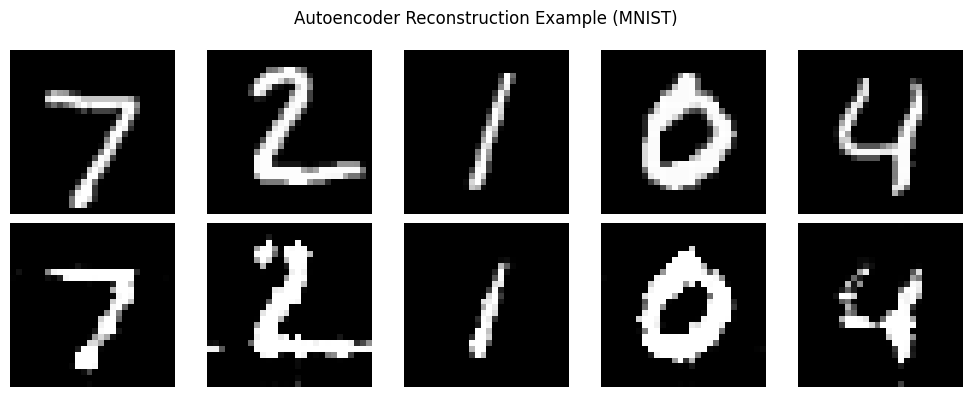

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================================================================
# 1. 데이터 생성 및 준비 (제공된 코드)
# =============================================================================

# 점, 선, 면 등이 섞인 임의의 이미지 생성 함수
def draw_composite_image(n_shapes=3):
    img = Image.new("L", (28, 28), color=0)
    draw = ImageDraw.Draw(img)

    for _ in range(n_shapes):
        choice = random.choice(["dot", "horizontal", "vertical", "diagonal", "cross"])
        if choice == "dot":
            x, y = random.randint(5, 23), random.randint(5, 23)
            draw.ellipse((x-2, y-2, x+2, y+2), fill=255)
        elif choice == "horizontal":
            y = random.randint(5, 23)
            draw.line((0, y, 27, y), fill=255, width=1)
        elif choice == "vertical":
            x = random.randint(5, 23)
            draw.line((x, 0, x, 27), fill=255, width=1)
        elif choice == "diagonal":
            if random.random() < 0.5:
                draw.line((0, 0, 27, 27), fill=255, width=1)
            else:
                draw.line((0, 27, 27, 0), fill=255, width=1)
        elif choice == "cross":
            x, y = random.randint(5, 23), random.randint(5, 23)
            draw.line((x, 0, x, 27), fill=255, width=1)
            draw.line((0, y, 27, y), fill=255, width=1)

    return np.array(img)

# 커스텀 데이터셋 클래스
class SyntheticPatternDataset(Dataset):
    def __init__(self, num_images=50000, n_shapes_range=(1, 5)):
        self.num_images = num_images
        self.n_shapes_range = n_shapes_range
        print("합성 이미지 데이터셋 생성 중...")
        self.data = [draw_composite_image(random.randint(*n_shapes_range)) for _ in tqdm(range(num_images))]

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img = self.data[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0
        return img_tensor, img_tensor # 오토인코더는 입력을 복원하는 것이 목표이므로 (입력, 타겟) 모두 이미지

# =============================================================================
# 2. 오토인코더 모델 정의
# =============================================================================

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # 인코더: 28x28 이미지를 latent_dim 차원의 벡터로 압축
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> 32x7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )

        # 디코더: latent_dim 차원의 벡터를 28x28 이미지로 복원
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 1x28x28
            nn.Sigmoid() # 픽셀 값을 0과 1 사이로 조정
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# =============================================================================
# 3. 메인 실행 로직
# =============================================================================

if __name__ == '__main__':
    # 하이퍼파라미터 설정
    EPOCHS = 10
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    LATENT_DIM = 64
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # --- 1단계: 합성 데이터로 오토인코더 학습 ---
    print("\n--- 1단계: 오토인코더 학습 시작 ---")
    synthetic_dataset = SyntheticPatternDataset()
    train_loader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = Autoencoder(latent_dim=LATENT_DIM).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        total_loss = 0
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            inputs, targets = data
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

    # --- 2단계: 학습된 인코더로 프로토타입 생성 ---
    print("\n--- 2단계: MNIST & Fashion-MNIST 프로토타입 생성 시작 ---")
    model.eval() # 평가 모드로 전환

    # 데이터셋 로드 (학습용)
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

    # 데이터로더 생성 (전체 데이터를 한 번에 처리하기 위해 배치 크기를 크게 설정)
    mnist_train_loader = DataLoader(mnist_train, batch_size=1024)
    fashion_train_loader = DataLoader(fashion_mnist_train, batch_size=1024)

    # 프로토타입 저장을 위한 텐서 초기화 (20개 클래스, 각 LATENT_DIM 차원)
    prototypes = torch.zeros(20, LATENT_DIM).to(DEVICE)
    class_counts = torch.zeros(20).to(DEVICE)

    with torch.no_grad():
        # MNIST(0-9) 프로토타입 계산
        for images, labels in tqdm(mnist_train_loader, desc="MNIST Train Prototypes"):
            images = images.to(DEVICE)
            latent_vectors = model.encoder(images)
            for i in range(len(labels)):
                label = labels[i]
                prototypes[label] += latent_vectors[i]
                class_counts[label] += 1

        # Fashion-MNIST(10-19) 프로토타입 계산
        for images, labels in tqdm(fashion_train_loader, desc="Fashion-MNIST Train Prototypes"):
            images = images.to(DEVICE)
            # Fashion-MNIST 레이블은 10~19로 매핑
            labels += 10
            latent_vectors = model.encoder(images)
            for i in range(len(labels)):
                label = labels[i]
                prototypes[label] += latent_vectors[i]
                class_counts[label] += 1

    # 각 클래스의 합계를 개수로 나누어 평균 벡터(프로토타입) 계산
    prototypes /= class_counts.unsqueeze(1)
    print("프로토타입 생성 완료!")

    # --- 3단계: 프로토타입 기반 분류 및 성능 평가 ---
    print("\n--- 3단계: 프로토타입 기반 분류 성능 평가 시작 ---")

    # 데이터셋 로드 (테스트용)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    mnist_test_loader = DataLoader(mnist_test, batch_size=1024)
    fashion_test_loader = DataLoader(fashion_mnist_test, batch_size=1024)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        # MNIST(0-9) 테스트
        for images, labels in tqdm(mnist_test_loader, desc="MNIST Test Evaluation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            latent_vectors = model.encoder(images)

            # 각 잠재 벡터와 모든 프로토타입 간의 거리 계산
            # (N, 64) -> (N, 1, 64), (20, 64) -> (1, 20, 64)
            # 브로드캐스팅을 통해 (N, 20, 64) 텐서에서 L2 거리 계산
            distances = torch.cdist(latent_vectors.unsqueeze(1), prototypes.unsqueeze(0)).squeeze(1)

            # 가장 거리가 가까운 프로토타입의 인덱스를 예측 레이블로 선택
            predictions = torch.argmin(distances, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        # Fashion-MNIST(10-19) 테스트
        for images, labels in tqdm(fashion_test_loader, desc="Fashion-MNIST Test Evaluation"):
            images = images.to(DEVICE)
            # Fashion-MNIST 레이블은 10~19로 매핑
            labels_offset = (labels + 10).to(DEVICE)
            latent_vectors = model.encoder(images)

            distances = torch.cdist(latent_vectors.unsqueeze(1), prototypes.unsqueeze(0)).squeeze(1)
            predictions = torch.argmin(distances, dim=1)

            total_correct += (predictions == labels_offset).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    print(f"\n========================================================")
    print(f"최종 분류 정확도: {accuracy:.2f}%")
    print(f"(총 {total_samples}개의 테스트 샘플 중 {total_correct}개 정답)")
    print(f"========================================================")

    # 오토인코더 복원 결과 시각화 (MNIST 테스트 데이터 중 일부)
    print("\n[참고] 오토인코더의 이미지 복원 결과 시각화")
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

    with torch.no_grad():
        sample_images, _ = next(iter(mnist_test_loader))
        sample_images = sample_images[:5].to(DEVICE)
        reconstructed_images = model(sample_images)

    for i in range(5):
        # 원본 이미지
        axes[0, i].imshow(sample_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # 복원된 이미지
        axes[1, i].imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Autoencoder Reconstruction Example (MNIST)")
    plt.tight_layout()
    plt.show()


[참고] 오토인코더의 이미지 복원 결과 시각화 (Fashion-MNIST)


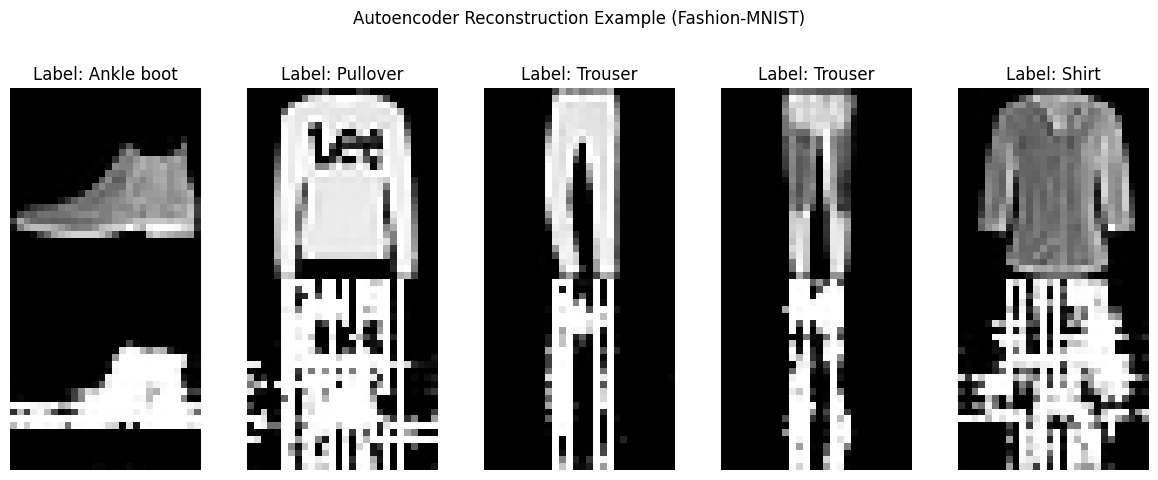

In [3]:
# [추가된 부분] 오토인코더 복원 결과 시각화 (Fashion-MNIST 테스트 데이터 중 일부)
print("\n[참고] 오토인코더의 이미지 복원 결과 시각화 (Fashion-MNIST)")

# Fashion-MNIST 클래스 이름 정의
fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

with torch.no_grad():
    # fashion_test_loader에서 데이터 가져오기
    sample_images, sample_labels = next(iter(fashion_test_loader))
    sample_images = sample_images[:5].to(DEVICE)
    reconstructed_images = model(sample_images)

for i in range(5):
    # 원본 이미지와 레이블
    original_img = sample_images[i].cpu().squeeze()
    label_text = fashion_mnist_labels[sample_labels[i]]
    axes[0, i].imshow(original_img, cmap='gray')
    axes[0, i].set_title(f"Label: {label_text}")
    axes[0, i].axis('off')

    # 복원된 이미지
    reconstructed_img = reconstructed_images[i].cpu().squeeze()
    axes[1, i].imshow(reconstructed_img, cmap='gray')
    axes[1, i].axis('off')

plt.suptitle("Autoencoder Reconstruction Example (Fashion-MNIST)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitle과 겹치지 않게 조정
plt.show()

In [4]:
    print("\n--- 2단계: MNIST 프로토타입 생성 시작 ---")
    model.eval() # 평가 모드로 전환

    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_train_loader = DataLoader(mnist_train, batch_size=1024)

    # 프로토타입 저장을 위한 텐서 초기화 (10개 클래스)
    prototypes = torch.zeros(10, LATENT_DIM).to(DEVICE)
    class_counts = torch.zeros(10).to(DEVICE)

    with torch.no_grad():
        for images, labels in tqdm(mnist_train_loader, desc="MNIST Train Prototypes"):
            images = images.to(DEVICE)
            latent_vectors = model.encoder(images)
            for i in range(len(labels)):
                label = labels[i]
                prototypes[label] += latent_vectors[i]
                class_counts[label] += 1

    prototypes /= class_counts.unsqueeze(1)
    print("MNIST 프로토타입 생성 완료!")

    # --- 3단계: 프로토타입 기반 분류 및 성능 평가 (MNIST Only) ---
    print("\n--- 3단계: MNIST 데이터로 성능 평가 시작 ---")

    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    mnist_test_loader = DataLoader(mnist_test, batch_size=1024)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(mnist_test_loader, desc="MNIST Test Evaluation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            latent_vectors = model.encoder(images)

            # 각 잠재 벡터와 10개의 프로토타입 간의 거리 계산
            distances = torch.cdist(latent_vectors.unsqueeze(1), prototypes.unsqueeze(0)).squeeze(1)

            # 가장 거리가 가까운 프로토타입의 인덱스를 예측 레이블로 선택
            predictions = torch.argmin(distances, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    print(f"\n========================================================")
    print(f"최종 MNIST 분류 정확도: {accuracy:.2f}%")
    print(f"(총 {total_samples}개의 MNIST 테스트 샘플 중 {total_correct}개 정답)")
    print(f"========================================================")



--- 2단계: MNIST 프로토타입 생성 시작 ---


MNIST Train Prototypes: 100%|██████████| 59/59 [00:14<00:00,  4.15it/s]


MNIST 프로토타입 생성 완료!

--- 3단계: MNIST 데이터로 성능 평가 시작 ---


MNIST Test Evaluation: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


최종 MNIST 분류 정확도: 81.76%
(총 10000개의 MNIST 테스트 샘플 중 8176개 정답)
